IMPORTS AND DATA PREPROCESSING

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import RANSACRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_log_error
import seaborn as sns
from itertools import combinations
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LassoCV
from sklearn.linear_model import ElasticNetCV
from sklearn.linear_model import SGDRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
path = './data/movies_dataset.csv'

df = pd.read_csv(path)

#We split the dataset intro train and test, and parameters and target
X = df.drop(columns=['Global_BoxOfficeUSD'])
y = df['Global_BoxOfficeUSD']

# Hacer el split ANTES de cualquier transformación
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,       # 20% test
    random_state=42,     # for replicability
    shuffle=True         
)

#We drop the columns that had a high correlation with 'Global_BoxOfficeUSD' as identified during the data cleaning
to_drop_hc = [
    'US_BoxOfficeUSD',       
    'Opening_Day_SalesUSD',  
    'One_Week_SalesUSD'     
]
to_drop_hc = [c for c in to_drop_hc if c in X_train.columns]
if len(to_drop_hc) > 0:
    X_train = X_train.drop(columns=to_drop_hc)
else:
    print("Columns have already been dropped")

#We extract year, month and day from the release date, useful to  detect seasonal patterns
X_train['ReleaseDate'] = pd.to_datetime(X_train['ReleaseDate'], dayfirst=True, errors='coerce')
X_train['ReleaseDate_Year'] = X_train['ReleaseDate'].dt.year
X_train['ReleaseDate_Month'] = X_train['ReleaseDate'].dt.month
X_train['ReleaseDate_Day'] = X_train['ReleaseDate'].dt.day

#Numerical column scaling
cols_to_scale = [
    'BudgetUSD', 
    'NumVotesIMDb', 'NumVotesRT',
    'IMDbRating', 'RottenTomatoesScore',
    'ReleaseDate_Year', 'ReleaseDate_Month', 'ReleaseDate_Day'
]
scaler = StandardScaler()
X_train_scaled = X_train.copy()
X_train_scaled[cols_to_scale] = scaler.fit_transform(X_train[cols_to_scale])

#We also drop some non-numerical columns that are not relevant for specific models
to_drop_n = [
    'MovieID',       
    'Title',  
    'Director',
    'LeadActor',
    'ReleaseYear', #numerical but duplicated, as we will convert ReleaseDate to separate year, month and day columns
    'ReleaseDate'  #already used, to get the year, month and day columns
]
to_drop_n = [c for c in to_drop_n if c in X_train_scaled.columns]
if len(to_drop_n) > 0:
    X_train_numerical = X_train_scaled.drop(columns=to_drop_n)
else:
    print("Columns have already been dropped")

#There are not too many different genres/countries, so they can be useful if we one-hot encode them
X_train_numerical = pd.get_dummies(X_train_numerical, columns=['Genre'], prefix='Genre')
X_train_numerical = pd.get_dummies(X_train_numerical, columns=['Country'], prefix='Country')

#We apply the same transformations to the test set

# Drop same correlated columns
X_test = X_test.drop(columns=to_drop_hc, errors='ignore')

# ReleaseDate → year / month / day
X_test['ReleaseDate'] = pd.to_datetime(X_test['ReleaseDate'], dayfirst=True, errors='coerce')
X_test['ReleaseDate_Year'] = X_test['ReleaseDate'].dt.year
X_test['ReleaseDate_Month'] = X_test['ReleaseDate'].dt.month
X_test['ReleaseDate_Day'] = X_test['ReleaseDate'].dt.day

# Scaling (use transform only!)
X_test_scaled = X_test.copy()
X_test_scaled[cols_to_scale] = scaler.transform(X_test[cols_to_scale])

# Drop the same non-numerical columns
X_test_numerical = X_test_scaled.drop(columns=to_drop_n, errors='ignore')

# One-hot encoding: ensure same columns as train
X_test_numerical = pd.get_dummies(X_test_numerical, columns=['Genre'], prefix='Genre')
X_test_numerical = pd.get_dummies(X_test_numerical, columns=['Country'], prefix='Country')

# Reindex to match train columns
X_test_numerical = X_test_numerical.reindex(columns=X_train_numerical.columns, fill_value=0)

print("Final dataset shape:", X_train_numerical.shape)
X_train_numerical.head()

Final dataset shape: (799999, 26)


,BudgetUSD,IMDbRating,RottenTomatoesScore,NumVotesIMDb,NumVotesRT,ReleaseDate_Year,ReleaseDate_Month,ReleaseDate_Day,Genre_Action,Genre_Comedy,...,Country_Australia,Country_Canada,Country_China,Country_France,Country_Germany,Country_India,Country_Japan,Country_South Korea,Country_UK,Country_USA
566853,-0.241545,0.675644,1.148362,-0.190588,0.638026,-0.312189,1.299563,-0.651791,False,True,...,False,False,False,False,True,False,False,False,False,False
382311,-0.047463,-0.939364,-1.068053,-0.353971,-0.200939,-0.571845,-1.312673,-0.651791,False,False,...,True,False,False,False,False,False,False,False,False,False
241519,-0.306311,-1.141241,-0.840729,-0.276840,-0.234123,0.674506,-0.151679,-0.197554,False,False,...,False,False,False,False,False,False,False,False,False,True
930120,-0.347633,0.810228,0.239064,-0.321399,-0.233175,0.622574,-0.151679,0.483803,False,False,...,False,False,False,False,False,False,False,False,False,True
911069,-0.421552,0.271892,-0.272417,-0.348078,-0.197384,0.310987,-1.602922,0.710922,True,False,...,False,False,False,False,False,False,False,False,False,True


SIMPLE LINEAR REGRESSION(We will predict the Global_BoxOfficeUSD based on the BudgetUSD)

In [3]:
#We prepare the data
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
# --- 1. DATA PREPARATION ---
# Define the Target Variable
target = 'Global_BoxOfficeUSD'

# Define X (Predictor) and y (Target)
# For Simple Regression, X must be a DataFrame with a single column (double brackets)
X_simple = df[['BudgetUSD']] 
y = df[target]

print(f"Predictor Variable (X): BudgetUSD")
print(f"Target Variable (y): {target}")

Predictor Variable (X): BudgetUSD
Target Variable (y): Global_BoxOfficeUSD



=== SIMPLE LINEAR REGRESSION RESULTS ===
R2 Score (Accuracy): 0.8039
RMSE (Root Mean Squared Error): $31,298,516.55
MAE (Mean Absolute Error):      $10,837,028.44


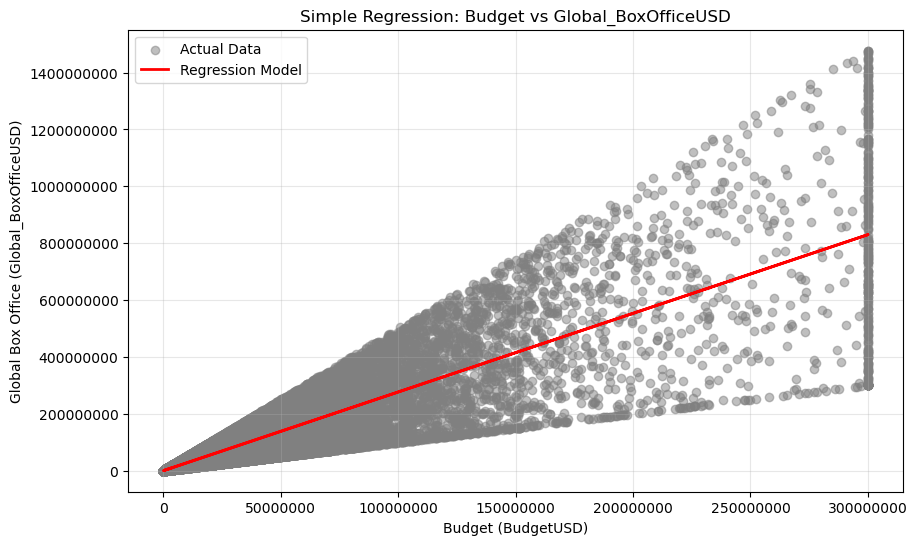


=== EVALUATION REPORT: SIMPLE REGRESSION ===
R2 Score (Train): 0.8013
R2 Score (Test):  0.8039
 STATUS: Healthy model (Good generalization).


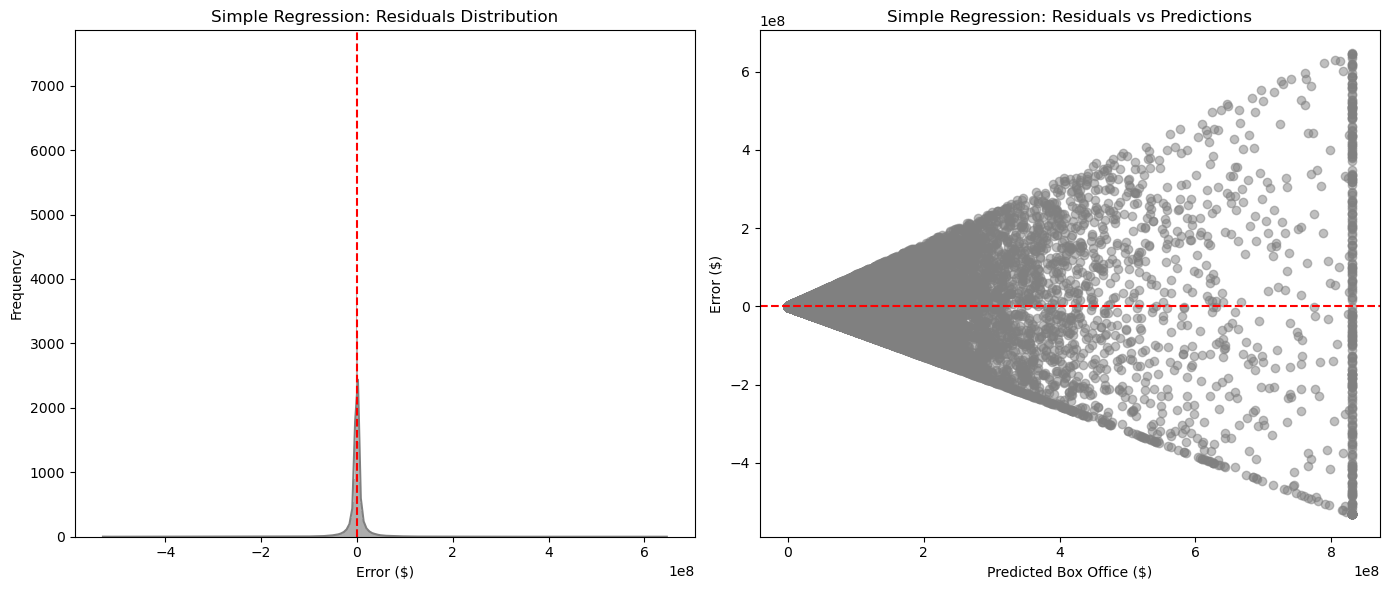

In [4]:

# --- 2. TRAIN / TEST SPLIT ---
# Split 80% for training and 20% for testing
X_train, X_test, y_train, y_test = train_test_split(
    X_simple, 
    y, 
    test_size=0.2, 
    random_state=42
)

# --- 3. SCALING (StandardScaler) ---
# Even for simple regression, it is good practice to scale money values
scaler = StandardScaler()

# Fit only on training data to avoid data leakage ("peeking" at the test set)
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# --- 4. MODEL TRAINING (OLS) ---
simple_model = LinearRegression()
simple_model.fit(X_train_scaled, y_train)

# --- 5. PREDICTION AND EVALUATION ---
y_pred = simple_model.predict(X_test_scaled)

# Calculate metrics
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)

print("\n=== SIMPLE LINEAR REGRESSION RESULTS ===")
print(f"R2 Score (Accuracy): {r2:.4f}")
print(f"RMSE (Root Mean Squared Error): ${rmse:,.2f}")
print(f"MAE (Mean Absolute Error):      ${mae:,.2f}")

# --- 6. VISUALIZATION ---
plt.figure(figsize=(10, 6))

# Pro Tip: Inverse transform the X-axis to show real Dollars, not standard deviations
X_test_real_dollars = scaler.inverse_transform(X_test_scaled)

# Real data points (Scatter)
plt.scatter(X_test_real_dollars, y_test, color='gray', alpha=0.5, label='Actual Data')

# Prediction line
plt.plot(X_test_real_dollars, y_pred, color='red', linewidth=2, label='Regression Model')

plt.title(f'Simple Regression: Budget vs {target}')
plt.xlabel('Budget (BudgetUSD)')
plt.ylabel('Global Box Office (Global_BoxOfficeUSD)')
plt.legend()
plt.grid(True, alpha=0.3)

# Format axes to avoid scientific notation (e.g., 1e9)
plt.ticklabel_format(style='plain', axis='both') 
plt.show()

#EVALUATION

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import r2_score

# --- 7. MODEL EVALUATION (Overfitting & Residuals) ---
# We use the 'simple_model' you just trained

print("\n=== EVALUATION REPORT: SIMPLE REGRESSION ===")

# 1. OVERFITTING CHECK
# Predict on both Train and Test sets to compare performance
y_train_pred = simple_model.predict(X_train_scaled)

# Calculate R2 Scores
r2_train = r2_score(y_train, y_train_pred)
r2_test = r2_score(y_test, y_pred)

print(f"R2 Score (Train): {r2_train:.4f}")
print(f"R2 Score (Test):  {r2_test:.4f}")

# Check the difference
diff = r2_train - r2_test
if diff > 0.10:
    print(f" WARNING: High Overfitting detected (Difference: {diff:.2f}).")
    print("The model explains the training data much better than the test data.")
elif diff < -0.05:
    print(f" Suspicious: Test score is better than Train score.")
else:
    print(f" STATUS: Healthy model (Good generalization).")

# 2. RESIDUALS ANALYSIS
# Calculate errors (Real - Predicted)
residuals = y_test - y_pred

plt.figure(figsize=(14, 6))

# Plot A: Residuals Distribution (Histogram)
# We want a bell curve centered at 0 (Normal Distribution)
plt.subplot(1, 2, 1)
sns.histplot(residuals, kde=True, color='gray')
plt.axvline(x=0, color='red', linestyle='--')
plt.title('Simple Regression: Residuals Distribution')
plt.xlabel('Error ($)')
plt.ylabel('Frequency')

# Plot B: Residuals vs. Predicted (Homoscedasticity)
# We want a random cloud of points. No funnel shapes.
plt.subplot(1, 2, 2)
plt.scatter(y_pred, residuals, alpha=0.5, color='gray')
plt.axhline(y=0, color='red', linestyle='--')
plt.title('Simple Regression: Residuals vs Predictions')
plt.xlabel('Predicted Box Office ($)')
plt.ylabel('Error ($)')

plt.tight_layout()
plt.show()

MULTIPLE LINEAR REGRESSION(We will predict the Global_BoxOfficeUSD based on multiple variables, we will try different algorithms)

In [5]:
print(f"Training Features Shape: {X_train_numerical.shape}")
print(f"Testing Features Shape:  {X_test_numerical.shape}")
print(f"Total Predictors (Columns): {X_train_numerical.shape[1]}")

Training Features Shape: (799999, 26)
Testing Features Shape:  (200000, 26)
Total Predictors (Columns): 26


ORDINARY LEAST SQUARES(OLS)

--- 1. ORDINARY LEAST SQUARES (OLS) ---
R2 Score: 0.8039
RMSE:     $31,298,743.60


C:\Users\lur.iturbide\AppData\Local\Temp\ipykernel_22336\443712074.py:48: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_coefs_original, y=top_coefs_original.index, palette=colors)


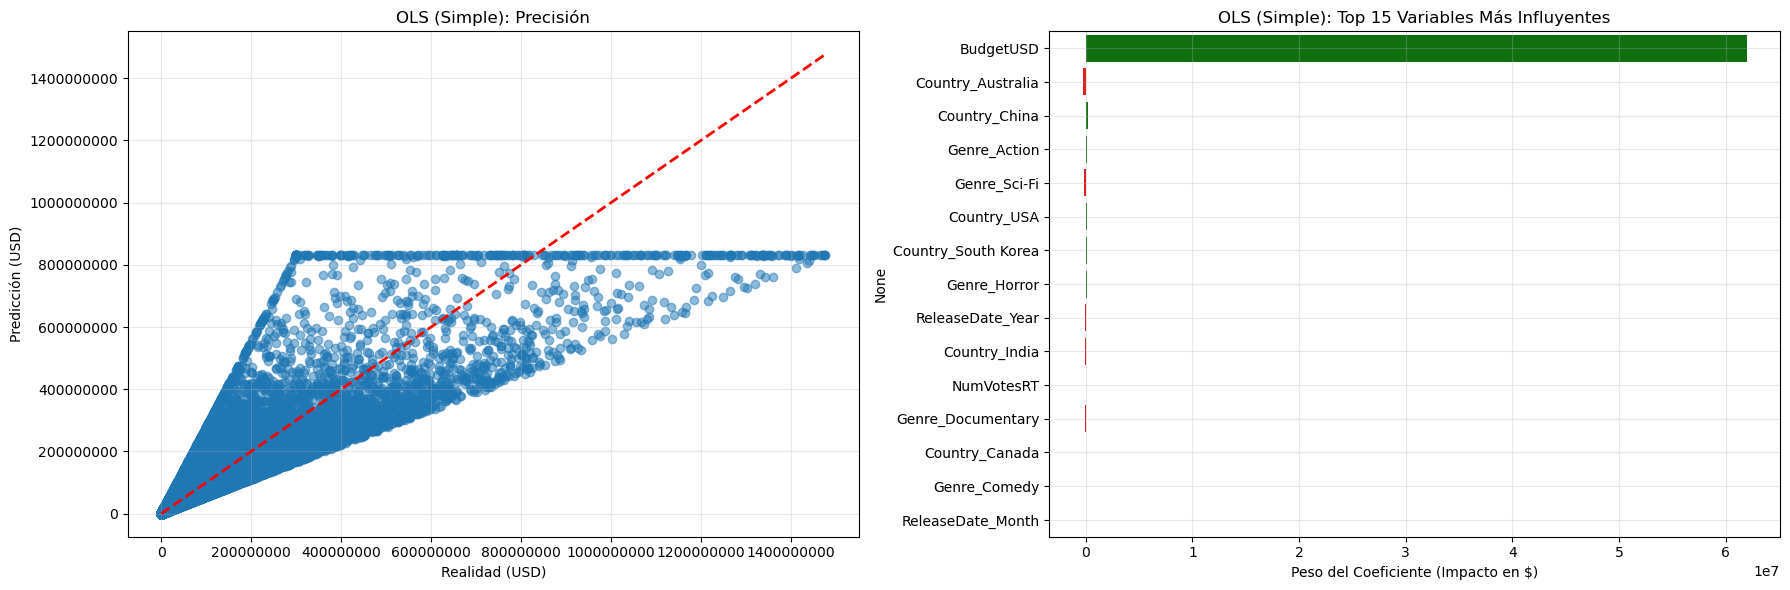


=== EVALUATION REPORT: OLS (Simple) ===
R2 Score (Train): 0.8013
R2 Score (Test):  0.8039
 STATUS: Healthy model (Good generalization).


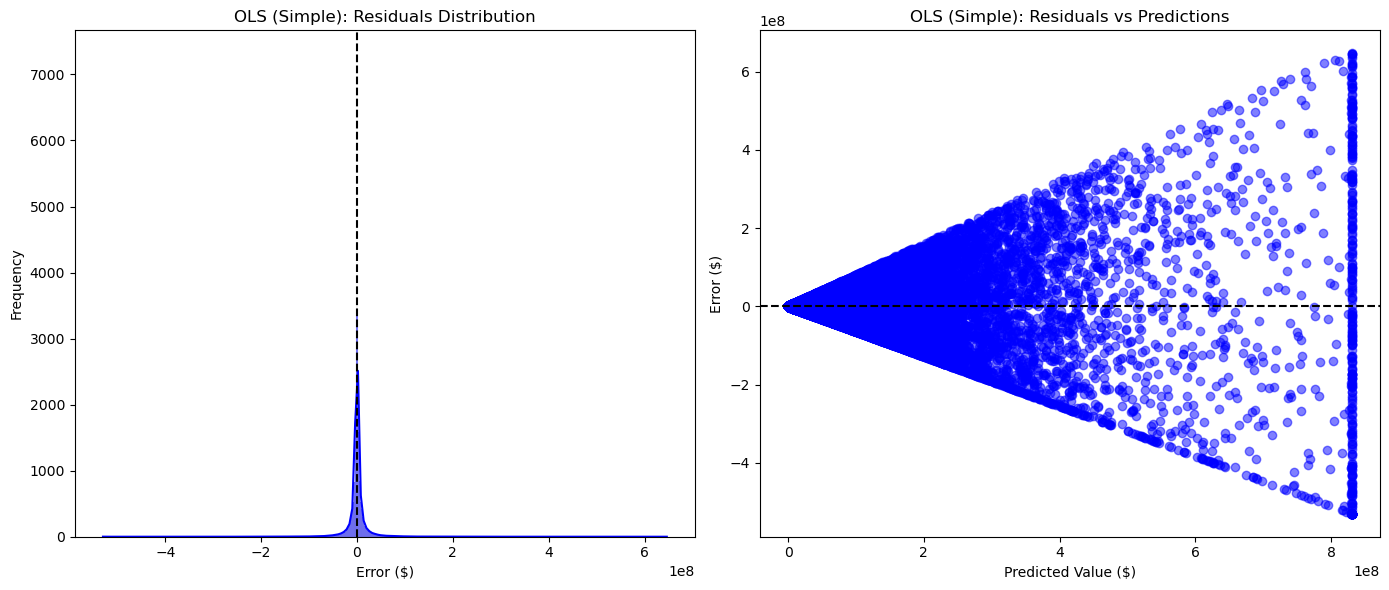

In [6]:
print("--- 1. ORDINARY LEAST SQUARES (OLS) ---")

# A. Initialize the model
ols_model = LinearRegression()

# B. Train the model using the processed training data
ols_model.fit(X_train_numerical, y_train) 

# C. Make predictions on the test set
y_pred_ols = ols_model.predict(X_test_numerical) 

# D. Evaluate metrics
r2_ols = r2_score(y_test, y_pred_ols)
rmse_ols = np.sqrt(mean_squared_error(y_test, y_pred_ols))

print(f"R2 Score: {r2_ols:.4f}")
print(f"RMSE:     ${rmse_ols:,.2f}")

#VISUALIZATION
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

model = ols_model
name = "OLS (Simple)"
y_pred = model.predict(X_test_numerical) 

plt.figure(figsize=(18, 6))

# Graph1: Reality vs Prediction
plt.subplot(1, 2, 1)
plt.scatter(y_test, y_pred, alpha=0.5, color='tab:blue')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Realidad (USD)')
plt.ylabel('Predicción (USD)')
plt.title(f'{name}: Precisión')
plt.grid(True, alpha=0.3)
plt.ticklabel_format(style='plain', axis='both')

# Graph2: Top Coefficients
plt.subplot(1, 2, 2)
coefs = pd.Series(model.coef_, index=X_test_numerical.columns)
top_coefs = coefs.abs().sort_values(ascending=False).head(15)
top_coefs_original = coefs[top_coefs.index]
colors = ['green' if x > 0 else 'red' for x in top_coefs_original]

sns.barplot(x=top_coefs_original, y=top_coefs_original.index, palette=colors)
plt.title(f'{name}: Top 15 Variables Más Influyentes')
plt.xlabel('Peso del Coeficiente (Impacto en $)')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

#EVALUATION

# --- EVALUATION: OLS (Ordinary Least Squares) ---
model_name = "OLS (Simple)"
current_model = ols_model

print(f"\n=== EVALUATION REPORT: {model_name} ===")

# 1. OVERFITTING CHECK
# Predict on Train set
y_train_pred = current_model.predict(X_train_numerical) 

# Calculate R2 Scores
r2_train = r2_score(y_train, y_train_pred)
r2_test = r2_score(y_test, y_pred_ols)

print(f"R2 Score (Train): {r2_train:.4f}")
print(f"R2 Score (Test):  {r2_test:.4f}")

# Check the difference
diff = r2_train - r2_test
if diff > 0.10:
    print(f" WARNING: High Overfitting detected (Difference: {diff:.2f}).")
elif diff < -0.05:
    print(f" Suspicious: Test score is better than Train score.")
else:
    print(f" STATUS: Healthy model (Good generalization).")

# 2. RESIDUALS ANALYSIS
residuals = y_test - y_pred_ols 

plt.figure(figsize=(14, 6))

# Plot A: Residuals Distribution (Histogram)
plt.subplot(1, 2, 1)
sns.histplot(residuals, kde=True, color='blue')
plt.axvline(x=0, color='black', linestyle='--')
plt.title(f'{model_name}: Residuals Distribution')
plt.xlabel('Error ($)')
plt.ylabel('Frequency')

# Plot B: Residuals vs. Predicted (Homoscedasticity)
plt.subplot(1, 2, 2)
plt.scatter(y_pred_ols, residuals, alpha=0.5, color='blue') 
plt.axhline(y=0, color='black', linestyle='--')
plt.title(f'{model_name}: Residuals vs Predictions')
plt.xlabel('Predicted Value ($)')
plt.ylabel('Error ($)')

plt.tight_layout()
plt.show()

RIDGE REGRESSION(L2 REGULARIZATION)


--- 2. RIDGE REGRESSION (L2) ---
R2 Score:   0.8039
RMSE:       $31,298,796.94
Best Alpha: 100.0


C:\Users\lur.iturbide\AppData\Local\Temp\ipykernel_22336\3858935675.py:43: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_coefs_original, y=top_coefs_original.index, palette=colors)


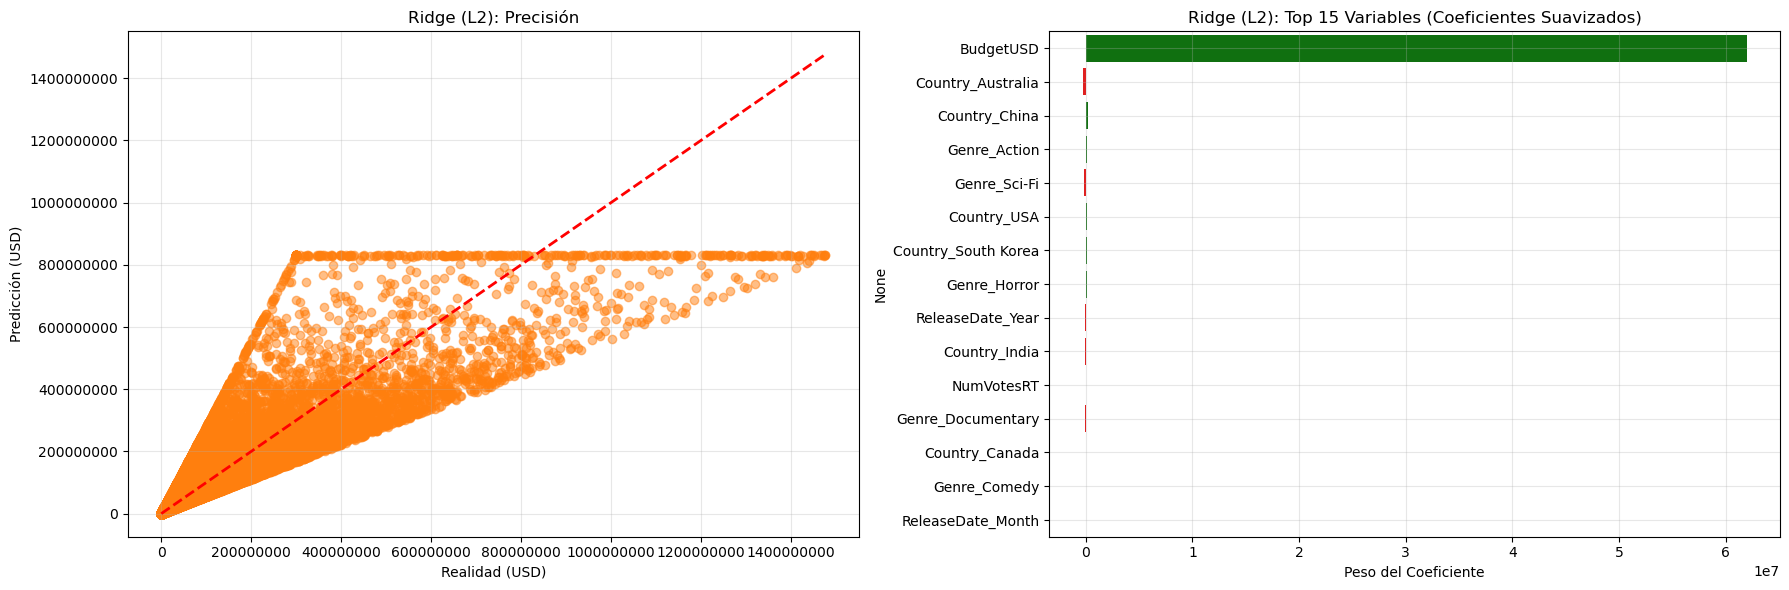


=== EVALUATION REPORT: Ridge (L2) ===
R2 Score (Train): 0.8013
R2 Score (Test):  0.8039
 STATUS: Healthy model (Good generalization).


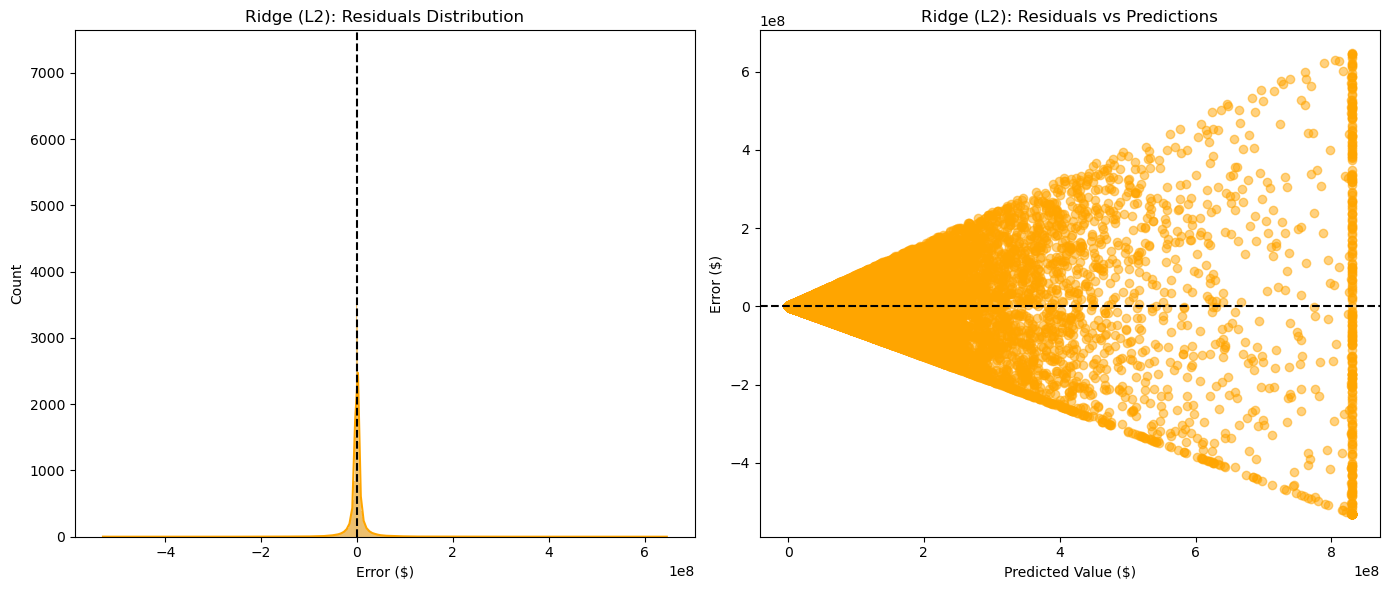

In [7]:
print("\n--- 2. RIDGE REGRESSION (L2) ---")

# A. Initialize Ridge with Cross-Validation (CV)
ridge_model = RidgeCV(alphas=[0.1, 1.0, 10.0, 50.0, 100.0])

# B. Train
ridge_model.fit(X_train_numerical, y_train) 

# C. Predict
y_pred_ridge = ridge_model.predict(X_test_numerical) 

# D. Evaluate
r2_ridge = r2_score(y_test, y_pred_ridge)
rmse_ridge = np.sqrt(mean_squared_error(y_test, y_pred_ridge))

print(f"R2 Score:   {r2_ridge:.4f}")
print(f"RMSE:       ${rmse_ridge:,.2f}")
print(f"Best Alpha: {ridge_model.alpha_}")

#VISUALIZATION
model = ridge_model
name = "Ridge (L2)"

plt.figure(figsize=(18, 6))

# Graph1: Reality vs Prediction
plt.subplot(1, 2, 1)
plt.scatter(y_test, y_pred_ridge, alpha=0.5, color='tab:orange') 
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Realidad (USD)')
plt.ylabel('Predicción (USD)')
plt.title(f'{name}: Precisión')
plt.grid(True, alpha=0.3)
plt.ticklabel_format(style='plain', axis='both')

# Graph2: Top Coefficients
plt.subplot(1, 2, 2)
coefs = pd.Series(model.coef_, index=X_test_numerical.columns) 
top_coefs = coefs.abs().sort_values(ascending=False).head(15)
top_coefs_original = coefs[top_coefs.index]
colors = ['green' if x > 0 else 'red' for x in top_coefs_original]

sns.barplot(x=top_coefs_original, y=top_coefs_original.index, palette=colors)
plt.title(f'{name}: Top 15 Variables (Coeficientes Suavizados)')
plt.xlabel('Peso del Coeficiente')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

#EVALUATION
# --- EVALUATION: RIDGE REGRESSION ---
model_name = "Ridge (L2)"
current_model = ridge_model

print(f"\n=== EVALUATION REPORT: {model_name} ===")

# 1. OVERFITTING CHECK
y_train_pred = current_model.predict(X_train_numerical)

r2_train = r2_score(y_train, y_train_pred)
r2_test = r2_score(y_test, y_pred_ridge)

print(f"R2 Score (Train): {r2_train:.4f}")
print(f"R2 Score (Test):  {r2_test:.4f}")

diff = r2_train - r2_test
if diff > 0.10:
    print(f" WARNING: High Overfitting detected (Difference: {diff:.2f}).")
else:
    print(f" STATUS: Healthy model (Good generalization).")

# 2. RESIDUALS ANALYSIS
residuals = y_test - y_pred_ridge 

plt.figure(figsize=(14, 6))

# Plot A: Distribution
plt.subplot(1, 2, 1)
sns.histplot(residuals, kde=True, color='orange')
plt.axvline(x=0, color='black', linestyle='--')
plt.title(f'{model_name}: Residuals Distribution')
plt.xlabel('Error ($)')

# Plot B: Residuals vs Predicted
plt.subplot(1, 2, 2)
plt.scatter(y_pred_ridge, residuals, alpha=0.5, color='orange') 
plt.axhline(y=0, color='black', linestyle='--')
plt.title(f'{model_name}: Residuals vs Predictions')
plt.xlabel('Predicted Value ($)')
plt.ylabel('Error ($)')

plt.tight_layout()
plt.show()

LASSO REGRESSION


--- 3. LASSO REGRESSION ---
R2 Score:   0.8039
RMSE:       $31,299,010.06
Features eliminated: 24 out of 26


C:\Users\lur.iturbide\AppData\Local\Temp\ipykernel_22336\3581310436.py:48: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_coefs_original, y=top_coefs_original.index, palette=colors)


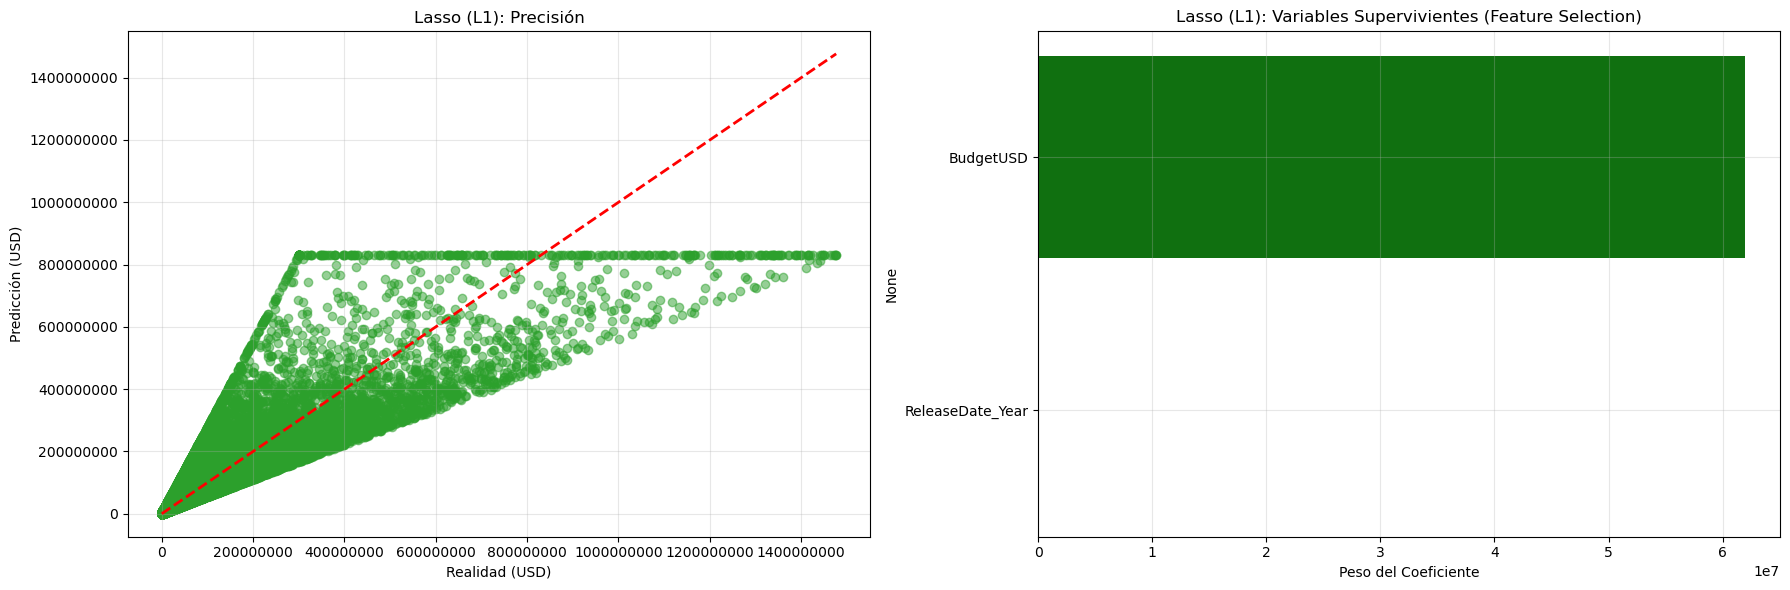

Lasso eliminó 24 variables irrelevantes.

=== EVALUATION REPORT: Lasso (L1) ===
R2 Score (Train): 0.8013
R2 Score (Test):  0.8039
 STATUS: Healthy model (Good generalization).


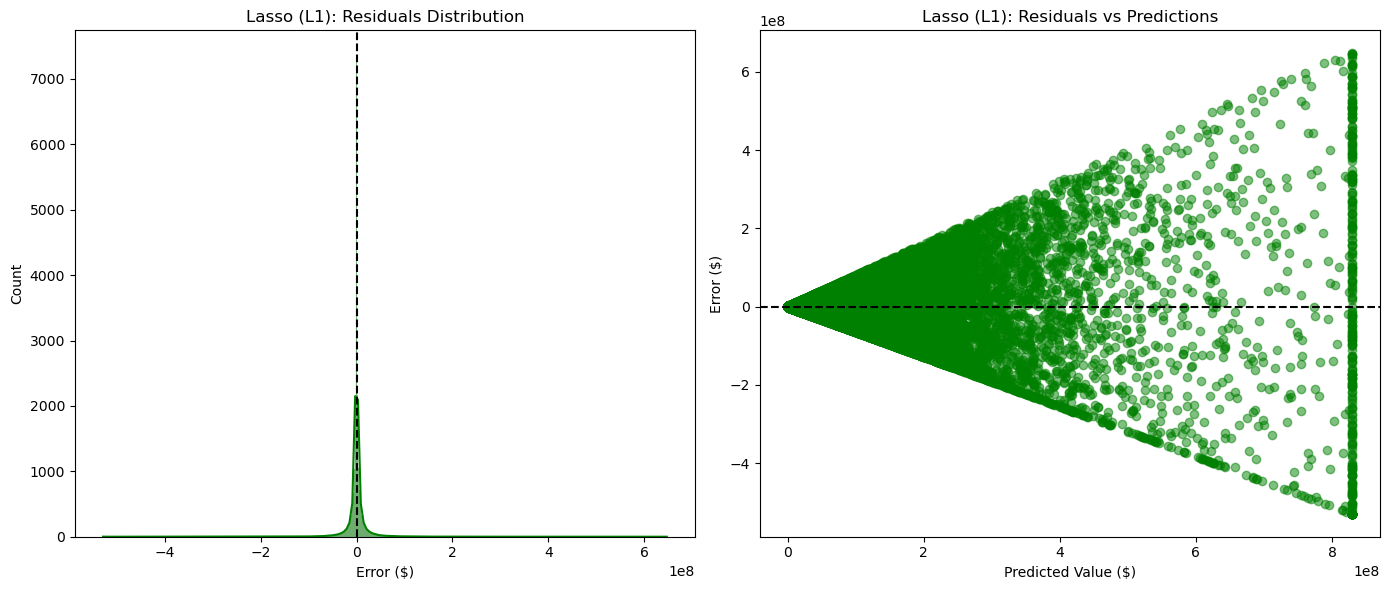

In [8]:
print("\n--- 3. LASSO REGRESSION ---")

# A. Initialize Lasso with CV
lasso_model = LassoCV(cv=5, random_state=42, max_iter=10000)

# B. Train
lasso_model.fit(X_train_numerical, y_train) 

# C. Predict
y_pred_lasso = lasso_model.predict(X_test_numerical) 

# D. Evaluate
r2_lasso = r2_score(y_test, y_pred_lasso)
rmse_lasso = np.sqrt(mean_squared_error(y_test, y_pred_lasso))

# Count how many features were ignored (coefficient became 0)
params_zero = np.sum(lasso_model.coef_ == 0)
total_params = len(lasso_model.coef_)

print(f"R2 Score:   {r2_lasso:.4f}")
print(f"RMSE:       ${rmse_lasso:,.2f}")
print(f"Features eliminated: {params_zero} out of {total_params}")

#VISUALIZATION
model = lasso_model
name = "Lasso (L1)"

plt.figure(figsize=(18, 6))

# Graph1: Reality vs Prediction
plt.subplot(1, 2, 1)
plt.scatter(y_test, y_pred_lasso, alpha=0.5, color='tab:green') 
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Realidad (USD)')
plt.ylabel('Predicción (USD)')
plt.title(f'{name}: Precisión')
plt.grid(True, alpha=0.3)
plt.ticklabel_format(style='plain', axis='both')

# Graph2: Top Coefficients
plt.subplot(1, 2, 2)
coefs = pd.Series(model.coef_, index=X_test_numerical.columns) 
coefs_active = coefs[coefs != 0]
top_coefs = coefs_active.abs().sort_values(ascending=False).head(15)
top_coefs_original = coefs_active[top_coefs.index]
colors = ['green' if x > 0 else 'red' for x in top_coefs_original]

sns.barplot(x=top_coefs_original, y=top_coefs_original.index, palette=colors)
plt.title(f'{name}: Variables Supervivientes (Feature Selection)')
plt.xlabel('Peso del Coeficiente')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Lasso eliminó {len(coefs) - len(coefs_active)} variables irrelevantes.")

#EVALUATION
# --- EVALUATION: LASSO REGRESSION ---
model_name = "Lasso (L1)"
current_model = lasso_model

print(f"\n=== EVALUATION REPORT: {model_name} ===")

# 1. OVERFITTING CHECK
y_train_pred = current_model.predict(X_train_numerical) 

r2_train = r2_score(y_train, y_train_pred)
r2_test = r2_score(y_test, y_pred_lasso) 

print(f"R2 Score (Train): {r2_train:.4f}")
print(f"R2 Score (Test):  {r2_test:.4f}")

diff = r2_train - r2_test
if diff > 0.10:
    print(f" WARNING: High Overfitting detected (Difference: {diff:.2f}).")
else:
    print(f" STATUS: Healthy model (Good generalization).")

# 2. RESIDUALS ANALYSIS
residuals = y_test - y_pred_lasso 

plt.figure(figsize=(14, 6))

# Plot A: Distribution
plt.subplot(1, 2, 1)
sns.histplot(residuals, kde=True, color='green')
plt.axvline(x=0, color='black', linestyle='--')
plt.title(f'{model_name}: Residuals Distribution')
plt.xlabel('Error ($)')

# Plot B: Residuals vs Predicted
plt.subplot(1, 2, 2)
plt.scatter(y_pred_lasso, residuals, alpha=0.5, color='green') 
plt.axhline(y=0, color='black', linestyle='--')
plt.title(f'{model_name}: Residuals vs Predictions')
plt.xlabel('Predicted Value ($)')
plt.ylabel('Error ($)')

plt.tight_layout()
plt.show()

ELASTIC NET REGRESSION


--- 4. ELASTIC NET ---
R2 Score:      0.0025
RMSE:          $70,594,700.07
Best L1 Ratio: 0.99


C:\Users\lur.iturbide\AppData\Local\Temp\ipykernel_22336\3954992082.py:43: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_coefs_original, y=top_coefs_original.index, palette=colors)


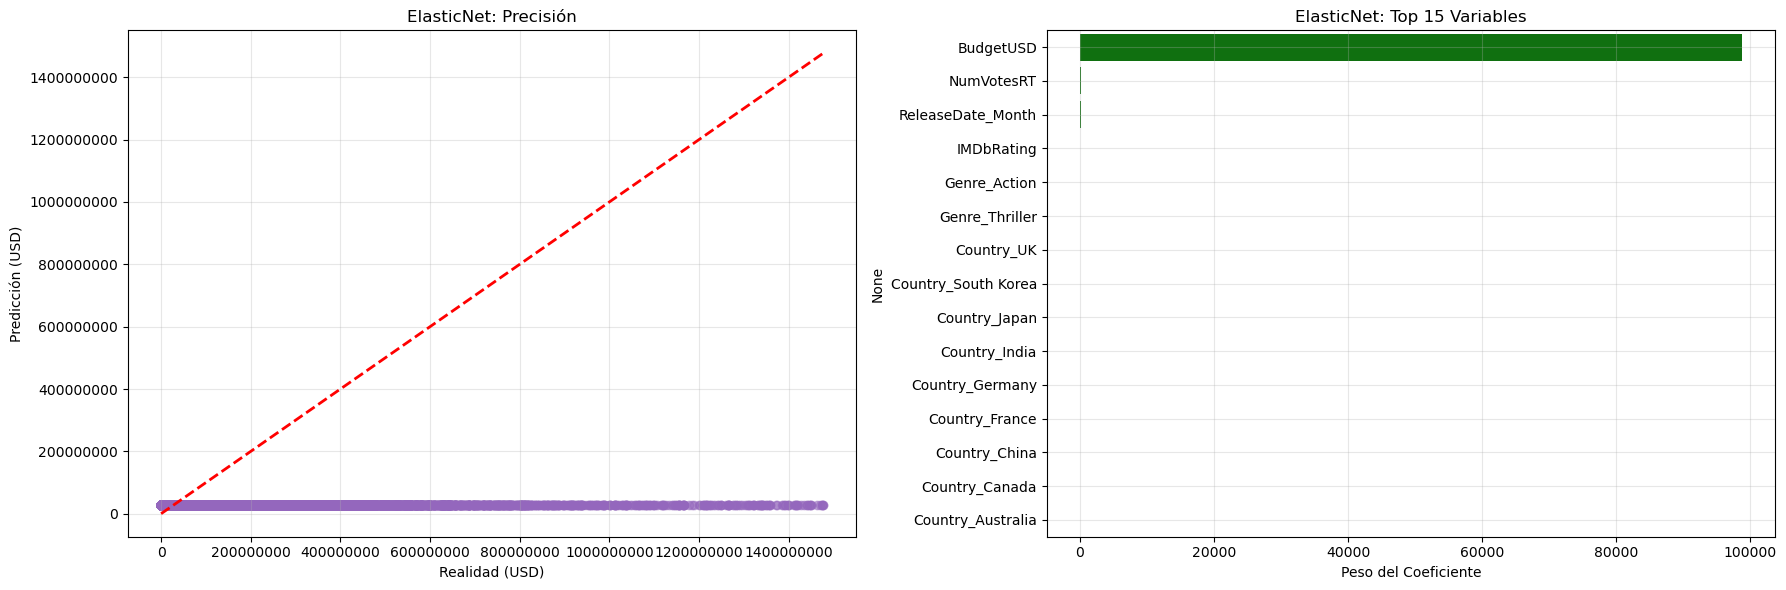


=== EVALUATION REPORT: ElasticNet ===
R2 Score (Train): 0.0026
R2 Score (Test):  0.0025
 STATUS: Healthy model (Good generalization).


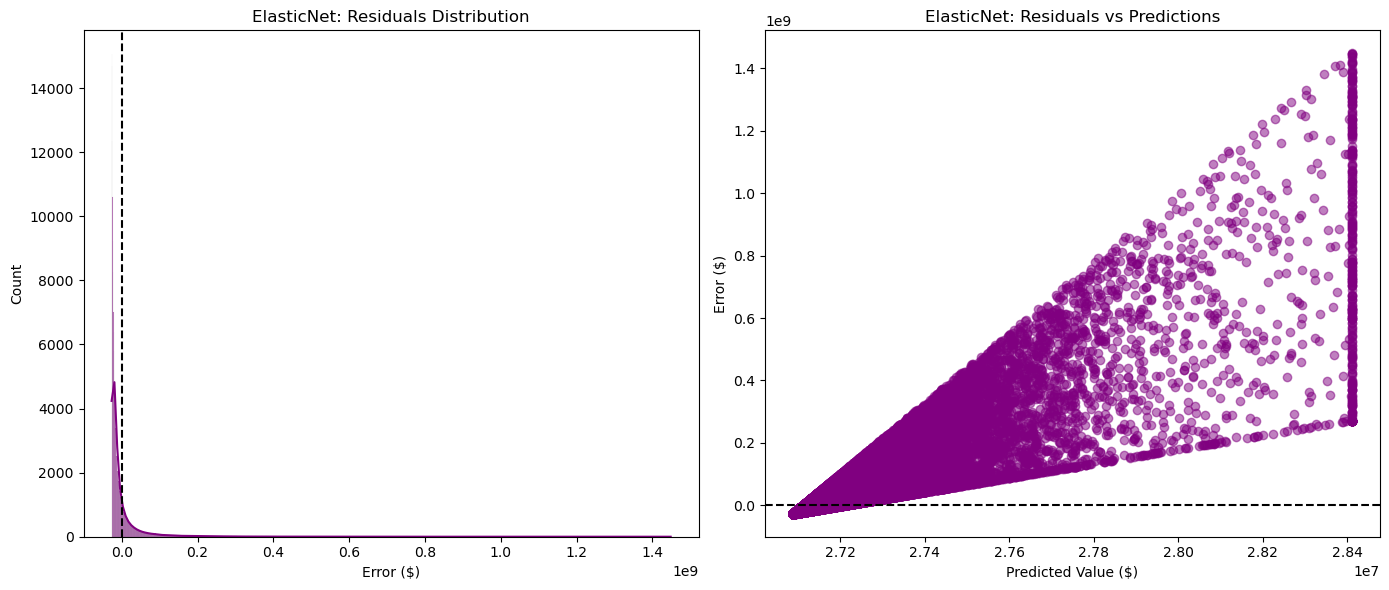

In [9]:
print("\n--- 4. ELASTIC NET ---")

# A. Initialize ElasticNet with CV
elastic_model = ElasticNetCV(l1_ratio=[.1, .5, .7, .9, .95, .99], cv=5, random_state=42, max_iter=10000)

# B. Train
elastic_model.fit(X_train_numerical, y_train) 

# C. Predict
y_pred_elastic = elastic_model.predict(X_test_numerical) 

# D. Evaluate
r2_elastic = r2_score(y_test, y_pred_elastic)
rmse_elastic = np.sqrt(mean_squared_error(y_test, y_pred_elastic))

print(f"R2 Score:      {r2_elastic:.4f}")
print(f"RMSE:          ${rmse_elastic:,.2f}")
print(f"Best L1 Ratio: {elastic_model.l1_ratio_}")

#VISUALIZATION
model = elastic_model
name = "ElasticNet"

plt.figure(figsize=(18, 6))

# Graph1: Reality vs Prediction
plt.subplot(1, 2, 1)
plt.scatter(y_test, y_pred_elastic, alpha=0.5, color='tab:purple') 
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Realidad (USD)')
plt.ylabel('Predicción (USD)')
plt.title(f'{name}: Precisión')
plt.grid(True, alpha=0.3)
plt.ticklabel_format(style='plain', axis='both')

# Graph2: Top Coefficients
plt.subplot(1, 2, 2)
coefs = pd.Series(model.coef_, index=X_test_numerical.columns) 
top_coefs = coefs.abs().sort_values(ascending=False).head(15)
top_coefs_original = coefs[top_coefs.index]
colors = ['green' if x > 0 else 'red' for x in top_coefs_original]

sns.barplot(x=top_coefs_original, y=top_coefs_original.index, palette=colors)
plt.title(f'{name}: Top 15 Variables')
plt.xlabel('Peso del Coeficiente')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

#EVALUATION
# --- EVALUATION: ELASTIC NET ---
model_name = "ElasticNet"
current_model = elastic_model

print(f"\n=== EVALUATION REPORT: {model_name} ===")

# 1. OVERFITTING CHECK
y_train_pred = current_model.predict(X_train_numerical)  

r2_train = r2_score(y_train, y_train_pred)
r2_test = r2_score(y_test, y_pred_elastic) 

print(f"R2 Score (Train): {r2_train:.4f}")
print(f"R2 Score (Test):  {r2_test:.4f}")

diff = r2_train - r2_test
if diff > 0.10:
    print(f" WARNING: High Overfitting detected (Difference: {diff:.2f}).")
else:
    print(f" STATUS: Healthy model (Good generalization).")

# 2. RESIDUALS ANALYSIS
residuals = y_test - y_pred_elastic 

plt.figure(figsize=(14, 6))

# Plot A: Distribution
plt.subplot(1, 2, 1)
sns.histplot(residuals, kde=True, color='purple')
plt.axvline(x=0, color='black', linestyle='--')
plt.title(f'{model_name}: Residuals Distribution')
plt.xlabel('Error ($)')

# Plot B: Residuals vs Predicted
plt.subplot(1, 2, 2)
plt.scatter(y_pred_elastic, residuals, alpha=0.5, color='purple')
plt.axhline(y=0, color='black', linestyle='--')
plt.title(f'{model_name}: Residuals vs Predictions')
plt.xlabel('Predicted Value ($)')
plt.ylabel('Error ($)')

plt.tight_layout()
plt.show()

STOCHASTIC GRADIENT DESCENT(SGD)


--- 5. SGD REGRESSOR ---
R2 Score: 0.8036
RMSE:     $31,323,878.57


C:\Users\lur.iturbide\AppData\Local\Temp\ipykernel_22336\2411706825.py:47: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_coefs_original, y=top_coefs_original.index, palette=colors)


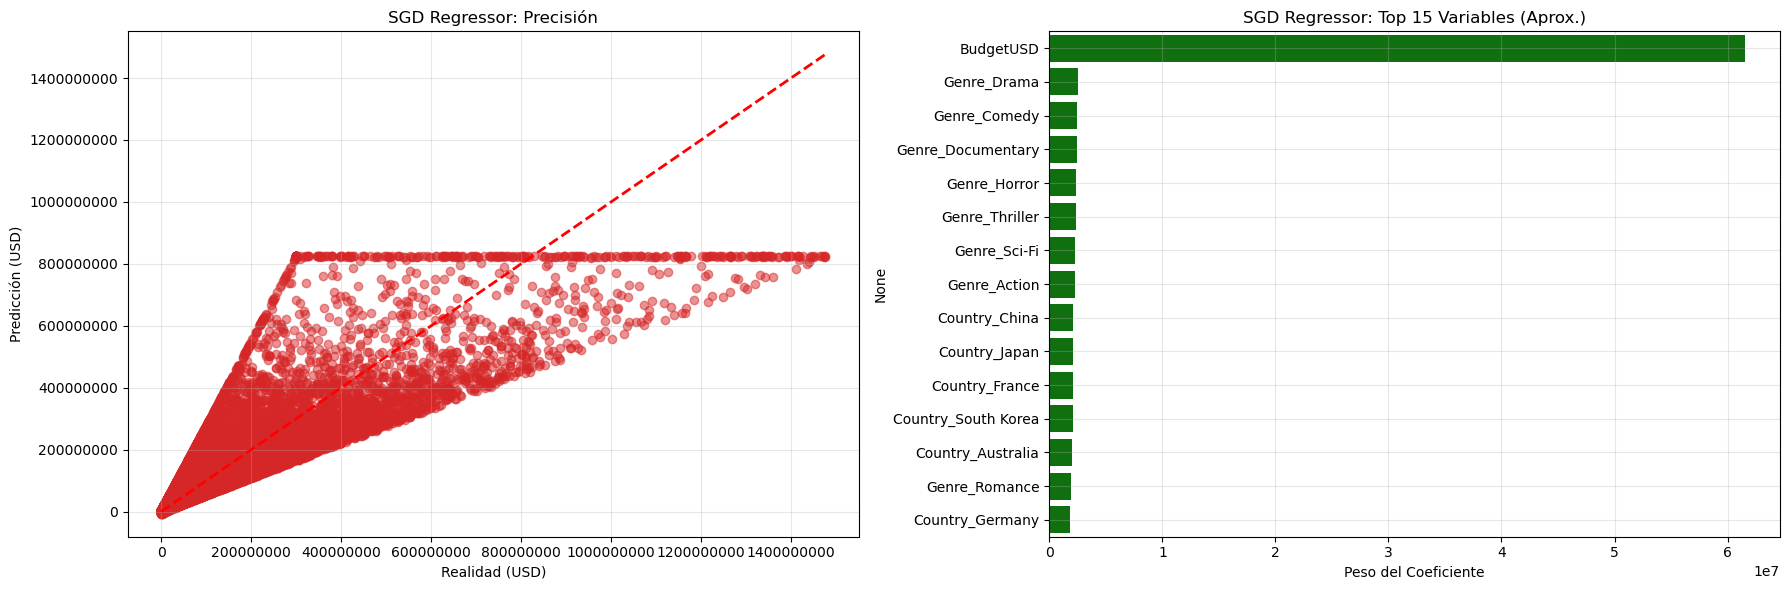


=== EVALUATION REPORT: SGD Regressor ===
R2 Score (Train): 0.8010
R2 Score (Test):  0.8036
 STATUS: Healthy model (Good generalization).


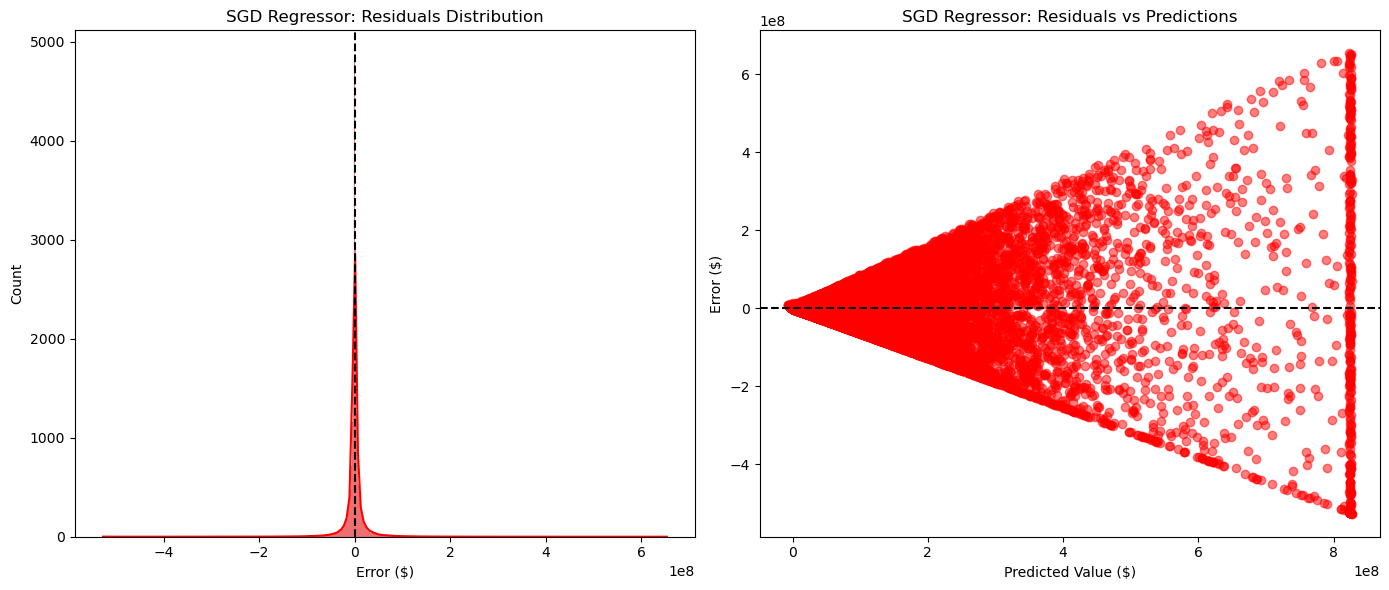

In [10]:
print("\n--- 5. SGD REGRESSOR ---")

# A. Initialize SGD
sgd_model = SGDRegressor(
    max_iter=1000, 
    tol=1e-3, 
    penalty='elasticnet', 
    random_state=42
)

# B. Train
sgd_model.fit(X_train_numerical, y_train) 

# C. Predict
y_pred_sgd = sgd_model.predict(X_test_numerical)  

# D. Evaluate
r2_sgd = r2_score(y_test, y_pred_sgd)
rmse_sgd = np.sqrt(mean_squared_error(y_test, y_pred_sgd))

print(f"R2 Score: {r2_sgd:.4f}")
print(f"RMSE:     ${rmse_sgd:,.2f}")

#VISUALIZATION
model = sgd_model
name = "SGD Regressor"

plt.figure(figsize=(18, 6))

# Graph1: Reality vs Prediction
plt.subplot(1, 2, 1)
plt.scatter(y_test, y_pred_sgd, alpha=0.5, color='tab:red') 
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Realidad (USD)')
plt.ylabel('Predicción (USD)')
plt.title(f'{name}: Precisión')
plt.grid(True, alpha=0.3)
plt.ticklabel_format(style='plain', axis='both')

# Graph2: Top Coefficients
plt.subplot(1, 2, 2)
coefs = pd.Series(model.coef_, index=X_test_numerical.columns) 
top_coefs = coefs.abs().sort_values(ascending=False).head(15)
top_coefs_original = coefs[top_coefs.index]
colors = ['green' if x > 0 else 'red' for x in top_coefs_original]

sns.barplot(x=top_coefs_original, y=top_coefs_original.index, palette=colors)
plt.title(f'{name}: Top 15 Variables (Aprox.)')
plt.xlabel('Peso del Coeficiente')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

#EVALUATION
# --- EVALUATION: SGD REGRESSOR ---
model_name = "SGD Regressor"
current_model = sgd_model

print(f"\n=== EVALUATION REPORT: {model_name} ===")

# 1. OVERFITTING CHECK
y_train_pred = current_model.predict(X_train_numerical) 

r2_train = r2_score(y_train, y_train_pred)
r2_test = r2_score(y_test, y_pred_sgd)  

print(f"R2 Score (Train): {r2_train:.4f}")
print(f"R2 Score (Test):  {r2_test:.4f}")

diff = r2_train - r2_test
if diff > 0.10:
    print(f" WARNING: High Overfitting detected (Difference: {diff:.2f}).")
else:
    print(f" STATUS: Healthy model (Good generalization).")

# 2. RESIDUALS ANALYSIS
residuals = y_test - y_pred_sgd 

plt.figure(figsize=(14, 6))

# Plot A: Distribution
plt.subplot(1, 2, 1)
sns.histplot(residuals, kde=True, color='red')
plt.axvline(x=0, color='black', linestyle='--')
plt.title(f'{model_name}: Residuals Distribution')
plt.xlabel('Error ($)')

# Plot B: Residuals vs Predicted
plt.subplot(1, 2, 2)
plt.scatter(y_pred_sgd, residuals, alpha=0.5, color='red') 
plt.axhline(y=0, color='black', linestyle='--')
plt.title(f'{model_name}: Residuals vs Predictions')
plt.xlabel('Predicted Value ($)')
plt.ylabel('Error ($)')

plt.tight_layout()
plt.show()

POLYNOMIAL REGRESSION(We will predict the Global_BoxOfficeUSD based on the BudgetUSD)

In [11]:
# --- POLYNOMIAL REGRESSION DATA PREPARATION ---

# Para polynomial regression, usamos solo 'BudgetUSD' para poder visualizar la curva
X_poly_train = X_train_numerical[['BudgetUSD']]
X_poly_test = X_test_numerical[['BudgetUSD']]

print(f"Predictor: BudgetUSD")
print(f"Target: Global_BoxOfficeUSD")
print(f"Train samples: {X_poly_train.shape[0]}")
print(f"Test samples: {X_poly_test.shape[0]}")

Predictor: BudgetUSD
Target: Global_BoxOfficeUSD
Train samples: 799999
Test samples: 200000


--- STARTING POLYNOMIAL REGRESSION (DEGREE 2) ---
Model trained successfully.

=== PERFORMANCE METRICS ===
R2 Score: 0.8039
RMSE:     $31,298,804.85
Model Coefficients: [6.19681189e+07 3.67974692e+03]


c:\Users\lur.iturbide\AppData\Local\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\lur.iturbide\AppData\Local\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(


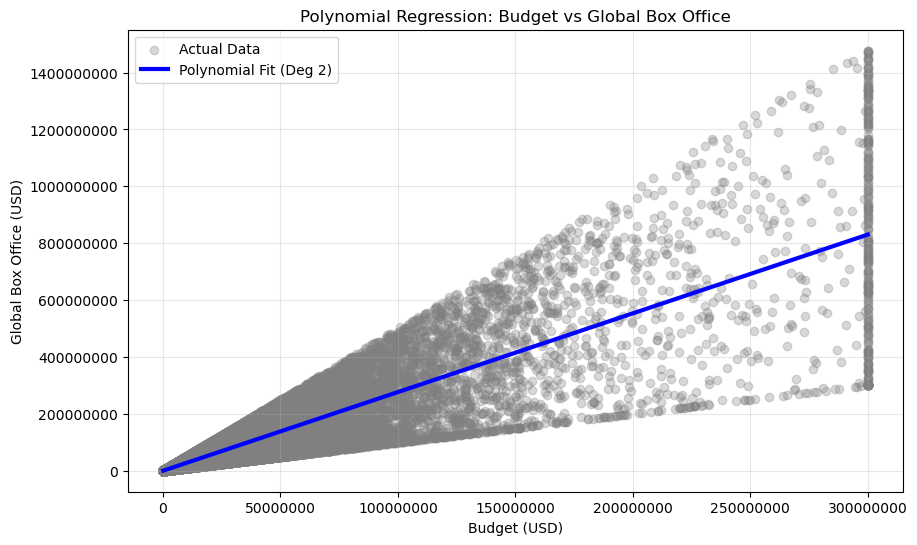


=== EVALUATION REPORT ===
R2 (Train): 0.8013
R2 (Test):  0.8039
 STATUS: Healthy model (Good generalization).


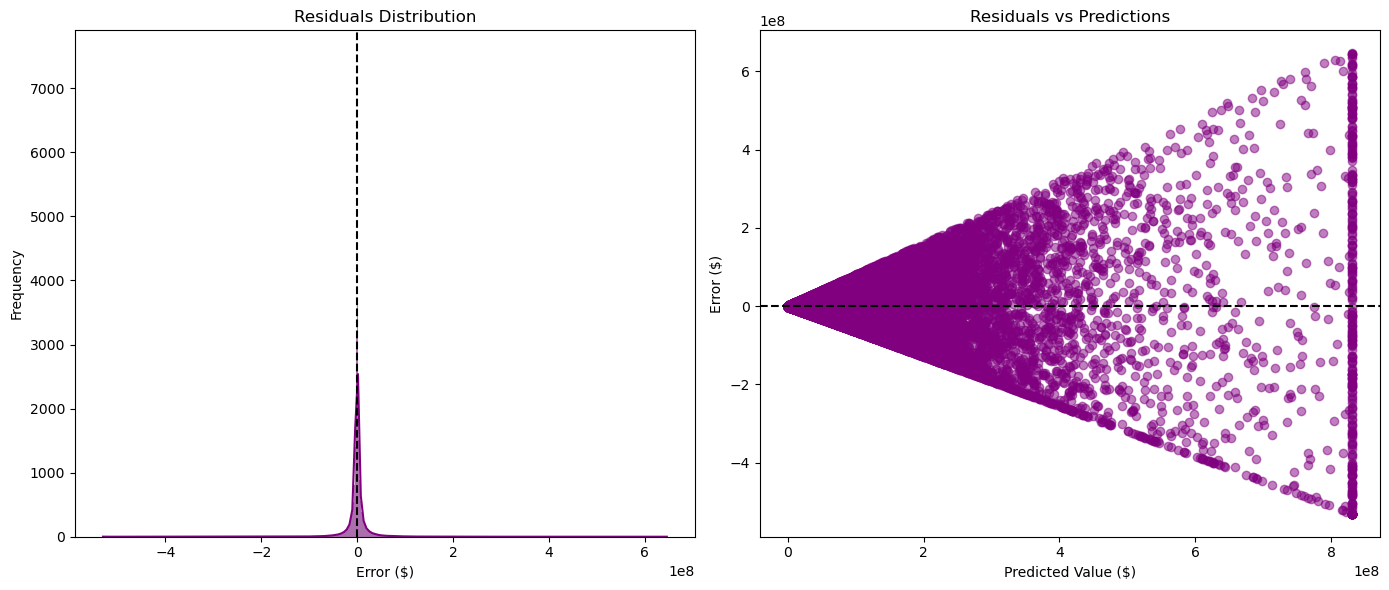

In [12]:
# --- CONFIGURATION ---
poly_degree = 2  # Degree 2 is usually sufficient for this type of data

print(f"--- STARTING POLYNOMIAL REGRESSION (DEGREE {poly_degree}) ---")

# --- 1. MODEL TRAINING ---
# Create a Pipeline: 
# 1. Generate Polynomial Features (x -> x, x^2)
# 2. Fit Linear Regression on those features
poly_model = Pipeline([
    ('poly', PolynomialFeatures(degree=poly_degree, include_bias=False)),
    ('linear', LinearRegression())
])

# Train the model on the scaled training data
poly_model.fit(X_poly_train, y_train) 
print("Model trained successfully.")

# --- 2. PREDICTION & BASIC METRICS ---
# Predict on the test set
y_pred_poly = poly_model.predict(X_poly_test) 

# Calculate standard metrics
r2 = r2_score(y_test, y_pred_poly)
rmse = np.sqrt(mean_squared_error(y_test, y_pred_poly))

print(f"\n=== PERFORMANCE METRICS ===")
print(f"R2 Score: {r2:.4f}")
print(f"RMSE:     ${rmse:,.2f}")

# Check linear coefficients to see if the curve is significant
linear_part = poly_model.named_steps['linear']
print(f"Model Coefficients: {linear_part.coef_}")


# --- 3. VISUALIZATION OF THE CURVE ---
plt.figure(figsize=(10, 6))

# A. Scatter plot of Real Test Data
# BudgetUSD ya está escalado, pero para visualización necesitamos crear un scaler
# Solo para poder hacer inverse_transform
scaler_viz = StandardScaler()
scaler_viz.fit(X_train[['BudgetUSD']])  # Fit con datos originales sin escalar

X_test_dollars = scaler_viz.inverse_transform(X_poly_test) 
plt.scatter(X_test_dollars, y_test, color='gray', alpha=0.3, label='Actual Data')

# B. Plotting the Smooth Curve
# Generate a range of values, scale them, and predict to get a smooth line
X_range = np.linspace(X_test_dollars.min(), X_test_dollars.max(), 100).reshape(-1, 1)
X_range_scaled = scaler_viz.transform(X_range) 
y_range_pred = poly_model.predict(X_range_scaled)

plt.plot(X_range, y_range_pred, color='blue', linewidth=3, label=f'Polynomial Fit (Deg {poly_degree})')

plt.title(f'Polynomial Regression: Budget vs Global Box Office')
plt.xlabel('Budget (USD)')
plt.ylabel('Global Box Office (USD)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.ticklabel_format(style='plain', axis='both')
plt.show()


# --- 4. DEEP EVALUATION (OVERFITTING & RESIDUALS) ---
print(f"\n=== EVALUATION REPORT ===")

# A. OVERFITTING CHECK
# Compare performance on Train data vs. Test data
y_train_pred = poly_model.predict(X_poly_train)
r2_train = r2_score(y_train, y_train_pred)
r2_test_final = r2_score(y_test, y_pred_poly)

print(f"R2 (Train): {r2_train:.4f}")
print(f"R2 (Test):  {r2_test_final:.4f}")

diff = r2_train - r2_test_final
if diff > 0.10:
    print(f" WARNING: High Overfitting detected (Difference: {diff:.2f}).")
    print("The curve is wiggling too much to fit the training points.")
elif diff < -0.05:
    print(f" Suspicious: Test score is significantly better than Train score.")
else:
    print(f" STATUS: Healthy model (Good generalization).")

# B. RESIDUALS ANALYSIS
# Calculate errors
residuals = y_test - y_pred_poly

plt.figure(figsize=(14, 6))

# Plot B1: Residuals Distribution (Histogram)
plt.subplot(1, 2, 1)
sns.histplot(residuals, kde=True, color='purple')
plt.axvline(x=0, color='black', linestyle='--')
plt.title('Residuals Distribution')
plt.xlabel('Error ($)')
plt.ylabel('Frequency')

# Plot B2: Residuals vs Predicted
plt.subplot(1, 2, 2)
plt.scatter(y_pred_poly, residuals, alpha=0.5, color='purple')
plt.axhline(y=0, color='black', linestyle='--')
plt.title('Residuals vs Predictions')
plt.xlabel('Predicted Value ($)')
plt.ylabel('Error ($)')

plt.tight_layout()
plt.show()

RANSAC

In [ ]:
ransac = RANSACRegressor(
  LinearRegression(),
  max_trials=500, 
  min_samples=0.5,
  residual_threshold=None,
  random_state=123)

ransac.fit(X_train_numerical, y_train)

,estimator,LinearRegression()
,min_samples,0.5
,residual_threshold,None
,is_data_valid,None
,is_model_valid,None
,max_trials,500
,max_skips,inf
,stop_n_inliers,inf
,stop_score,inf
,stop_probability,0.99
,loss,'absolute_error'


In [ ]:
y_pred = ransac.predict(X_test_numerical)

RANSAC - Model Evaluation

In [36]:
# Mean Absolute Error
mae = mean_absolute_error(y_test, y_pred)
print(f"MAE: {mae:.2f}")

# R²
r2 = r2_score(y_test, y_pred)
print(f"R²: {r2:.4f}")

# Adjusted R²  
n = X_test_numerical.shape[0]     
p = X_test_numerical.shape[1]     
adjusted_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1)
print(f"Adjusted R²: {adjusted_r2:.4f}")


#  Mean Squared Log Error
y_pred_positive = np.maximum(y_pred, 1) #we correct negative values that make msle not work
msle = mean_squared_log_error(y_test, y_pred_positive)
print(f"MSLE: {msle:.6f}")


MAE: 10836914.43
R²: 0.8039
Adjusted R²: 0.8039
MSLE: 0.284673


Theil-Sen

In [16]:
# --- PART 1A: DATA PREPARATION FOR MANUAL IMPLEMENTATION ---
import numpy as np
import matplotlib.pyplot as plt
from itertools import combinations

print("\n=== 1. MANUAL IMPLEMENTATION (Data Prep) ===")

# 1. PREPARE REAL DATA SAMPLE
# We use the data processed by your partner (X_train_scaled, y_train).
# IMPORTANT: Theil-Sen compares ALL pairs. We must use a small sample (e.g., 500 movies)
# or the manual loop will take forever to finish.
n_manual_sample = 500 

if 'X_train_scaled' in globals():
    # Randomly select 500 real movies from the training set
    np.random.seed(42)
    indices = np.random.choice(X_train_scaled.shape[0], n_manual_sample, replace=False)
    
    # Flatten X to 1D array for the manual formula
    x_real = X_train_scaled[indices, 0].flatten() #TE AÑADO AQUÍ EL , 0 PARA QUE COJA LA PRIMERA COLUMNA (BUDGETUSD)(SUPUESTAMENTE ASI ESTA MEJOR Y NO DA ERRORES)
    
    # Handle y depending on if it's a pandas Series or numpy array
    if hasattr(y_train, 'values'):
        y_real = y_train.iloc[indices].values
    else:
        y_real = y_train[indices]
        
    print(f"Using a subset of {len(x_real)} real movies for manual calculation.")
else:
    print("Error: Please run your partner's Data Preprocessing cell first.")
    # Fallback just in case variables don't exist
    x_real = np.array([1, 2, 3, 4, 5])
    y_real = np.array([2, 4, 6, 8, 100])


=== 1. MANUAL IMPLEMENTATION (Data Prep) ===
Using a subset of 500 real movies for manual calculation.


In [17]:
# --- PART 1B: MANUAL FUNCTION DEFINITION ---

def theil_sen_manual(x, y):
    """
    Calculates the median slope by checking all possible pairs of points.
    Formula: Slope_ij = (y_j - y_i) / (x_j - x_i)
    """
    n = len(x)
    slopes = []

    # Loop through all combinations of pairs (O(N^2) complexity)
    for i, j in combinations(range(n), 2):
        # Avoid division by zero (if two movies have exact same budget)
        if x[j] != x[i]:
            slope = (y[j] - y[i]) / (x[j] - x[i])
            slopes.append(slope)

    if not slopes:
        return 0, 0 

    # The Logic: Take the Median of all slopes to ignore outliers
    median_slope = np.median(slopes)
    
    # Calculate intercepts and take their median
    intercepts = y - median_slope * x
    median_intercept = np.median(intercepts)

    return median_slope, median_intercept

print("Function 'theil_sen_manual' defined successfully.")

Function 'theil_sen_manual' defined successfully.


Calculating slopes manually (this might take a moment)...

--- Manual Result on Movie Data ---
Calculated Slope (m):    61723622.0181
Calculated Intercept (b): 27106183.2945
Equation: BoxOffice = 61723622.02 * Budget + 27106183.29


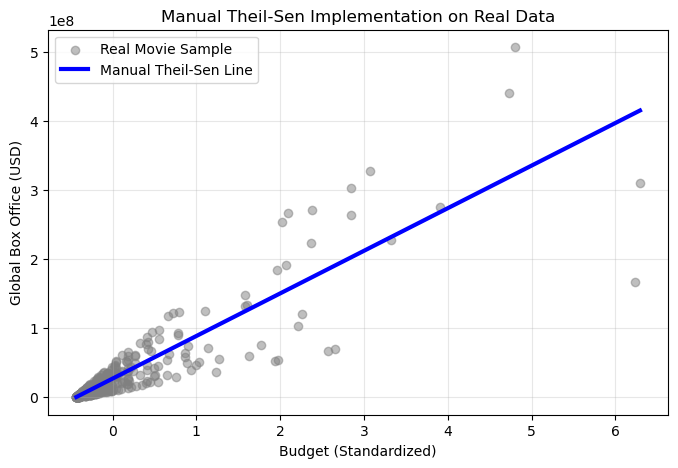

In [18]:
# --- PART 1C: EXECUTION & VISUALIZATION ---

# 3. EXECUTE ON REAL DATA
print("Calculating slopes manually (this might take a moment)...")
m_manual, b_manual = theil_sen_manual(x_real, y_real)

print(f"\n--- Manual Result on Movie Data ---")
print(f"Calculated Slope (m):    {m_manual:.4f}")
print(f"Calculated Intercept (b): {b_manual:.4f}")
print(f"Equation: BoxOffice = {m_manual:.2f} * Budget + {b_manual:.2f}")

# 4. VISUALIZATION
plt.figure(figsize=(8, 5))
# Plot the Real Data Sample
plt.scatter(x_real, y_real, color='gray', alpha=0.5, label='Real Movie Sample')

# Plot the Manually Calculated Line
x_line = np.array([x_real.min(), x_real.max()])
y_line = m_manual * x_line + b_manual

plt.plot(x_line, y_line, color='blue', linewidth=3, label='Manual Theil-Sen Line')

plt.title('Manual Theil-Sen Implementation on Real Data')
plt.xlabel('Budget (Standardized)')
plt.ylabel('Global Box Office (USD)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

Model Evaluation

HUBBER

Computed δ (Huber threshold): 8851259.564849999

----- Huber Regression Evaluation -----
MAE: 10843129.50846523
MSE: 982645050756396.4
RMSE: 31347169.740766015
R²: 0.8033221201611105


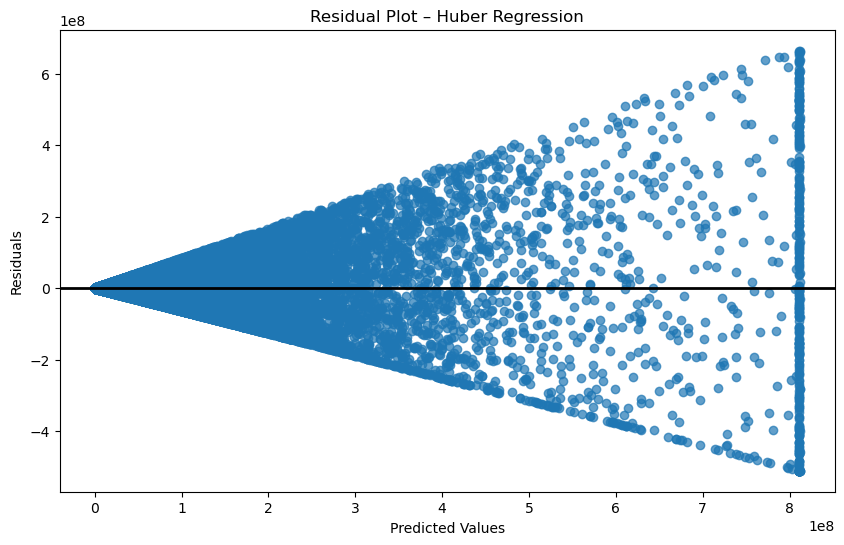

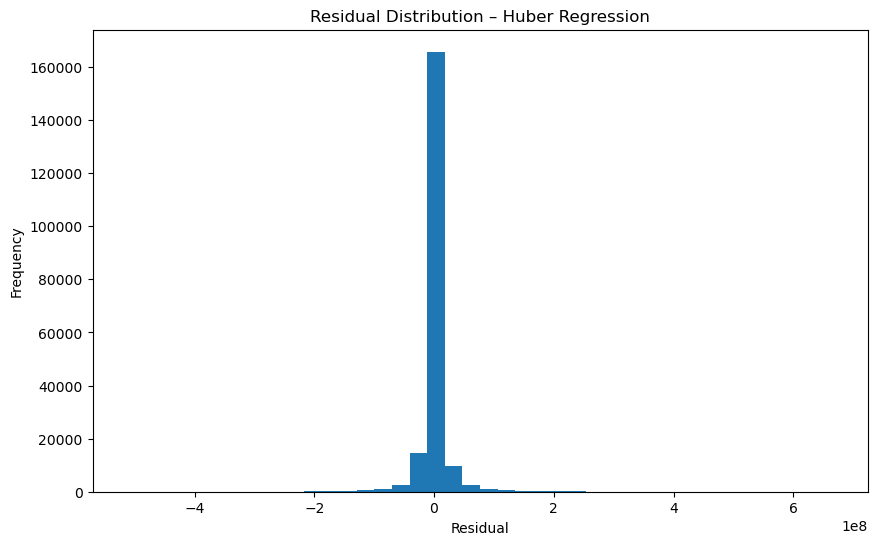


Huber Model Coefficients:
BudgetUSD: 60600045.13684148
US_BoxOfficeUSD: 6138.346445032975
Opening_Day_SalesUSD: -7621.537262069509
One_Week_SalesUSD: 4547.536272614195
IMDbRating: 1699.193944133858
RottenTomatoesScore: -6771.622628278568
NumVotesIMDb: 2575.805135131188
NumVotesRT: 1495.4081302042564

Huber Intercept: 26594874.57536944


In [23]:
###############################################
# Huber Regression – Preprocessing + Modeling #
###############################################

# Select numerical features for regression (same structure as RANSAC)
numerical_features = [
    'BudgetUSD', 'US_BoxOfficeUSD', 'Opening_Day_SalesUSD',
    'One_Week_SalesUSD', 'IMDbRating', 'RottenTomatoesScore',
    'NumVotesIMDb', 'NumVotesRT'
]


X = df.drop(columns=['Global_BoxOfficeUSD'])  #SAME AS IMPORTS
y = df['Global_BoxOfficeUSD'] #SAME AS IMPORTS

X_train_input = X_train_numerical.copy()
X_test_input = X_test_numerical.copy()

###############################################
# 1. Train–Test Split (BEFORE transformations)
###############################################
#from sklearn.model_selection import train_test_split

###############################################
# 2. Preprocessing (Scaling AFTER the split)
###############################################
#from sklearn.preprocessing import StandardScaler

#scaler = StandardScaler()

# Fit scaler ONLY on training data
#X_train_scaled = scaler.fit_transform(X_train)
#X_test_scaled = scaler.transform(X_test)

###############################################
# 3. Compute δ using MAD (Median Absolute Deviation)
###############################################

import numpy as np

# Step 1: Initialize coefficients to zero → prediction = 0
baseline_pred = np.zeros_like(y_train)

# Step 2 & 3: Compute residuals
residuals = y_train - baseline_pred

# Step 4: MAD
mad = np.median(np.abs(residuals - np.median(residuals)))

# δ calculation
delta_value = 1.345 * mad

print("Computed δ (Huber threshold):", delta_value)

###############################################
# 4. Train Huber Regressor
###############################################
from sklearn.linear_model import HuberRegressor

huber = HuberRegressor(
    epsilon=1.345,      # our MAD-based δ
    alpha=0.0001,             # small regularization (adjustable)
    max_iter=1000
)

huber.fit(X_train_input, y_train)

###############################################
# 5. Predictions
###############################################
y_pred = huber.predict(X_test_input)

###############################################
# 6. Model Evaluation
###############################################
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print("\n----- Huber Regression Evaluation -----")
print("MAE:", mae)
print("MSE:", mse)
print("RMSE:", rmse)
print("R²:", r2)

###############################################
# 7. Residual Analysis (Mandatory)
###############################################
import matplotlib.pyplot as plt

residuals_test = y_test - y_pred

plt.figure(figsize=(10, 6))
plt.scatter(y_pred, residuals_test, alpha=0.7)
plt.axhline(0, color='black', linewidth=2)
plt.title("Residual Plot – Huber Regression")
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.show()

# Distribution of residuals
plt.figure(figsize=(10, 6))
plt.hist(residuals_test, bins=40)
plt.title("Residual Distribution – Huber Regression")
plt.xlabel("Residual")
plt.ylabel("Frequency")
plt.show()

###############################################
# 8. Print Model Coefficients for Inspection
###############################################
print("\nHuber Model Coefficients:")
for feature, coef in zip(numerical_features, huber.coef_):
    print(f"{feature}: {coef}")

print("\nHuber Intercept:", huber.intercept_)


In [24]:
###############################################
# 8. Print Model Coefficients for Inspection
###############################################
print("\nHuber Model Coefficients:")

# Sanity check: same length
if len(huber.coef_) != X_train_input.shape[1]:
    print("Warning: number of coefficients does not match number of input features!")
    
for feature, coef in zip(X_train_input.columns, huber.coef_):
    print(f"{feature}: {coef}")

print("\nHuber Intercept:", huber.intercept_)



Huber Model Coefficients:
BudgetUSD: 60600045.13684148
IMDbRating: 6138.346445032975
RottenTomatoesScore: -7621.537262069509
NumVotesIMDb: 4547.536272614195
NumVotesRT: 1699.193944133858
ReleaseDate_Year: -6771.622628278568
ReleaseDate_Month: 2575.805135131188
ReleaseDate_Day: 1495.4081302042564
Genre_Action: 17250.73550085666
Genre_Comedy: -6663.234429009577
Genre_Documentary: -34629.96296894995
Genre_Drama: -10860.537711763629
Genre_Horror: 32495.33661697124
Genre_Romance: -7638.659253073798
Genre_Sci-Fi: -5270.570019604185
Genre_Thriller: -17521.959029987403
Country_Australia: -32301.316552283653
Country_Canada: -25481.970176770006
Country_China: 10490.922527558238
Country_France: 39231.98941523914
Country_Germany: -17484.63137078669
Country_India: -5051.095696228825
Country_Japan: -10463.926220573881
Country_South Korea: 44960.72929663887
Country_UK: -32600.569194517037
Country_USA: -4138.9833226675

Huber Intercept: 26594874.57536944


In [ ]:
###############################################
# Preprocessing ampliado (estilo "script")
# - Selección target, eliminación columnas no útiles/leakage
# - Split (antes de transformar)
# - Transformaciones aprendidas SOLO en train: imputación, winsorize (opcional),
#   log en columnas monetarias (opcional), RobustScaler, dummies con reindex
# Salidas: X_train_proc, X_test_proc, y_train, y_test, scaler, medians, train_columns
###############################################

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler

# ----------------- CONFIGURABLE -----------------
# Ajusta estas variables según necesites
PATH = './data/movies_dataset.csv'   # si necesitas recargar el df
DROP_COLS = ['Title', 'Plot', 'MovieID', 'Poster', 'TrailerURL', 'Columns have already been dropped']
EXCLUDE_FOR_LEAKAGE = ['US_BoxOfficeUSD']  # columnas que podrían filtrarse (leakage)
TEST_SIZE = 0.2
RANDOM_STATE = 123
USE_LOG_TARGET = True        # aplicar log1p al target (recomendado si target está muy sesgado)
LOG_MONEY_COLS = True        # aplicar log1p a columnas con keywords monetarios
MONEY_KEYWORDS = ['budget', 'boxoffice', 'box_office', 'sales', 'usd', 'gross', 'opening', 'revenue']
# ------------------------------------------------

# Si df no está en memoria, descomenta la línea siguiente para cargarlo:
# 1) Comprobar target
if target_variable not in df.columns:
    raise KeyError(f"Target '{target_variable}' no encontrado en df. Columnas disponibles: {df.columns.tolist()}")

# 2) Drop de columnas inútiles si existen
to_drop_n = [c for c in DROP_COLS if c in df.columns]
if to_drop_n:
    print("Eliminando columnas innecesarias:", to_drop_n)
    df = df.drop(columns=to_drop_n)

# 3) Eliminar columnas de leakage (opcional pero recomendado para evaluación justa)
leak_cols_present = [c for c in EXCLUDE_FOR_LEAKAGE if c in df.columns]
if leak_cols_present:
    print("Eliminando columnas por posible leakage:", leak_cols_present)
    df = df.drop(columns=leak_cols_present)

# 4) Definir X,y (sin transformar)
# Si quieres usar la lista numerical_features forzada, verificamos que existan en df.
if numerical_features is not None:
    missing_feats = [c for c in numerical_features if c not in df.columns]
    if missing_feats:
        print("Advertencia: algunas numerical_features no están en df:", missing_feats)
    X = df[[c for c in numerical_features if c in df.columns]].copy()
else:
    # Detectar automáticamente numéricas + categóricas (usamos todas las columnas excepto target)
    X = df.drop(columns=[target_variable]).copy()

y = df[target_variable].copy()

# 5) (Opcional) ver un par de estadísticas rápidas
print("Tamaño total data (antes split):", df.shape)
print("Features seleccionadas para X:", X.columns.tolist())

# 6) Aplicar split ANTES de ajustar transformaciones (evita leakage)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE
)
print("Split realizado. Train:", X_train.shape, "Test:", X_test.shape)

# 7) Aplicar log1p al target si lo queremos
if USE_LOG_TARGET:
    # Comprobamos coherencia (evitar transformar negativos)
    if (y_train < 0).any() or (y_test < 0).any():
        raise ValueError("El target contiene valores negativos; no es seguro aplicar log1p.")
    y_train = np.log1p(y_train)
    y_test  = np.log1p(y_test)
    print("Aplicado log1p al target.")

# 8) Detectar numéricas/categóricas en TRAIN para tomar decisiones
num_cols = X_train.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = X_train.select_dtypes(include=['object', 'category']).columns.tolist()
print("Columnas numéricas (train):", num_cols)
print("Columnas categóricas (train):", cat_cols)

# 9) Detectar columnas monetarias heurísticamente y aplicar log1p si pedimos
money_cols = [c for c in num_cols if any(k in c.lower() for k in MONEY_KEYWORDS)]
print("Money-like cols detectadas:", money_cols)

if LOG_MONEY_COLS and money_cols:
    # Aplicar la misma transform a train y test
    for c in money_cols:
        # Evitamos transformar negativos
        X_train[c] = X_train[c].apply(lambda v: np.log1p(v) if pd.notnull(v) and v >= 0 else v)
        X_test[c]  = X_test[c].apply(lambda v: np.log1p(v) if pd.notnull(v) and v >= 0 else v)
    print("Aplicado log1p a columnas monetarias en train y test.")

# 11) Imputación de numéricas usando medianas del TRAIN (aplicar mismas medianas al TEST)
medians = X_train[num_cols].median()
X_train_num = X_train[num_cols].fillna(medians)
X_test_num  = X_test[num_cols].fillna(medians)
print("Imputadas NaNs numéricas con medianas del train.")

# 12) Escalado robusto: fit en TRAIN, transform en TEST (RobustScaler)
scaler = RobustScaler()
X_train_num_scaled = pd.DataFrame(scaler.fit_transform(X_train_num), columns=num_cols, index=X_train.index)
X_test_num_scaled  = pd.DataFrame(scaler.transform(X_test_num), columns=num_cols, index=X_test.index)
print("Aplicado RobustScaler a numéricas (fit en train → transform en test).")

# 13) Categóricas: pd.get_dummies en TRAIN y reindex TEST a columnas del TRAIN (para alinear dummies)
if cat_cols:
    X_train_cat = pd.get_dummies(X_train[cat_cols].fillna('NA'), columns=cat_cols)
    X_test_cat  = pd.get_dummies(X_test[cat_cols].fillna('NA'), columns=cat_cols)
    # Reindex test para tener exactamente las mismas columnas que train (añade cols faltantes con 0)
    X_test_cat = X_test_cat.reindex(columns=X_train_cat.columns, fill_value=0)
    print("Creado One-Hot encoding (pd.get_dummies) sobre categóricas y reindexado test.")
else:
    # DataFrames vacíos para concatenar sin problemas
    X_train_cat = pd.DataFrame(index=X_train.index)
    X_test_cat  = pd.DataFrame(index=X_test.index)
    print("No hay columnas categóricas detectadas; se omite one-hot.")

# 14) Concatenar partes numéricas escaladas + dummies categóricas
X_train_proc = pd.concat([X_train_num_scaled, X_train_cat], axis=1)
X_test_proc  = pd.concat([X_test_num_scaled, X_test_cat], axis=1)

# 15) Asegurar orden/columnas idénticas (reindex por seguridad)
X_test_proc = X_test_proc.reindex(columns=X_train_proc.columns, fill_value=0)

print("Preprocessing finalizado.")
print("X_train_proc shape:", X_train_proc.shape)
print("X_test_proc shape:", X_test_proc.shape)

# 16) Guardar artefactos útiles para producción/inspección
train_columns = X_train_proc.columns.tolist()
print("Número de features finales:", len(train_columns))
print("Primeras 20 features:", train_columns[:20])
print("Medianas usadas (preview):", medians.head().to_dict())

# Ahora las variables listas para el entrenamiento son:
# X_train_proc (DataFrame), X_test_proc (DataFrame), y_train, y_test (Series)
# scaler (RobustScaler), medians (Series), train_columns (lista) -> para salvar/usar en producción
###############################################


NameError: name 'target_variable' is not defined